- Drop Id column, do not boxcox it or treat it as a categorical column
- change impute fill or drop the columns
- some continuous and categoricals could be put into a KBinsDiscretizer instead of numerical

In [1]:
import os
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import Counter

import tensorflow as tf
import keras


np.random.seed(43)
tf.random.set_seed(43)

# fetch the local data
#DATA_PATH = os.path.join('.','datasets','Prudential-Life-Insurance-Assessment')
#TRAIN_PATH = os.path.join(DATA_PATH,'train.csv')
#TEST_PATH = os.path.join(DATA_PATH,'test.csv')
#df_train = pd.read_csv(TRAIN_PATH)
#df_test = pd.read_csv(TEST_PATH)

# fetch the Kaggle data
DATA_PATH = os.path.join('..','input','prudentiallifeinsuranceassessment')
df_train = pd.read_csv(os.path.join(DATA_PATH,'train.csv'))
df_test = pd.read_csv(os.path.join(DATA_PATH,'test.csv'))

Using TensorFlow backend.


### Data Exploration

In [2]:
def uncompl_cols(df):
    """Takes a DataFrame and returns the columns which have at least one null-value,
    returning them as an pandas IndexObject"""
    return df.columns[df_train.isnull().any()]

print(uncompl_cols(df_train))

def df_perc_mis_values(df):
    """returns a DataFrame with index being the columns with at least one null-value
    and computes the percentage of null-values"""
    dic = {}
    for col_name in uncompl_cols(df):
        dic[col_name] = df[col_name].isnull().sum() / len(df.index)
    return pd.DataFrame.from_dict(dic, orient = 'index', columns = ['perc of null'])
    
df_missing = df_perc_mis_values(df_train)
df_missing

Index(['Employment_Info_1', 'Employment_Info_4', 'Employment_Info_6',
       'Insurance_History_5', 'Family_Hist_2', 'Family_Hist_3',
       'Family_Hist_4', 'Family_Hist_5', 'Medical_History_1',
       'Medical_History_10', 'Medical_History_15', 'Medical_History_24',
       'Medical_History_32'],
      dtype='object')


,perc of null
Employment_Info_1,0.000320
Employment_Info_4,0.114161
Employment_Info_6,0.182786
Insurance_History_5,0.427679
Family_Hist_2,0.482579
Family_Hist_3,0.576632
Family_Hist_4,0.323066
Family_Hist_5,0.704114
Medical_History_1,0.149694
Medical_History_10,0.990620


I am not quite sure how to proceed with the missing data. Some columns are missing that much data that imputing values seems to be artificial and that we should drop the whole. We will decide later. According to the Prudential description, there are four main categories:
- categorical
- continuous
- discrete
- dummy

We will first sort out the different categories and then take a look on some diagrams:

In [3]:
# separate the column names

dummy_cols = list(df_train.filter(axis='columns', like='Medical_Keyword_').columns)
disc_cols = ['Medical_History_' + str(i) for i in [1,10,15,24,32]] # all have missing values!
cont_cols = ['Product_Info_4', 'Ins_Age', 'Ht', 'Wt', 'BMI', 'Employment_Info_1', 'Employment_Info_4',
             'Employment_Info_6', 'Insurance_History_5', 'Family_Hist_2', 'Family_Hist_3',
             'Family_Hist_4', 'Family_Hist_5']
cat_cols = list(df_train.drop(columns=['Response']+dummy_cols+disc_cols+cont_cols).columns)

print("""Numbers of dummy_cols, disc_cols, cont_cols, cat_cols equals number of columns of 
dataframe without label:""",
     len(dummy_cols+disc_cols+cont_cols+cat_cols) == len(df_train.drop(columns=['Response']).columns))

Numbers of dummy_cols, disc_cols, cont_cols, cat_cols equals number of columns of 
dataframe without label: True


Note that all columns of disc_cols have missing data (exactly where medical history misses data), and that all Family_History, Insurance_History as well as Employment_Info columns with missing data are in cont_cols.

#### Dummy columns

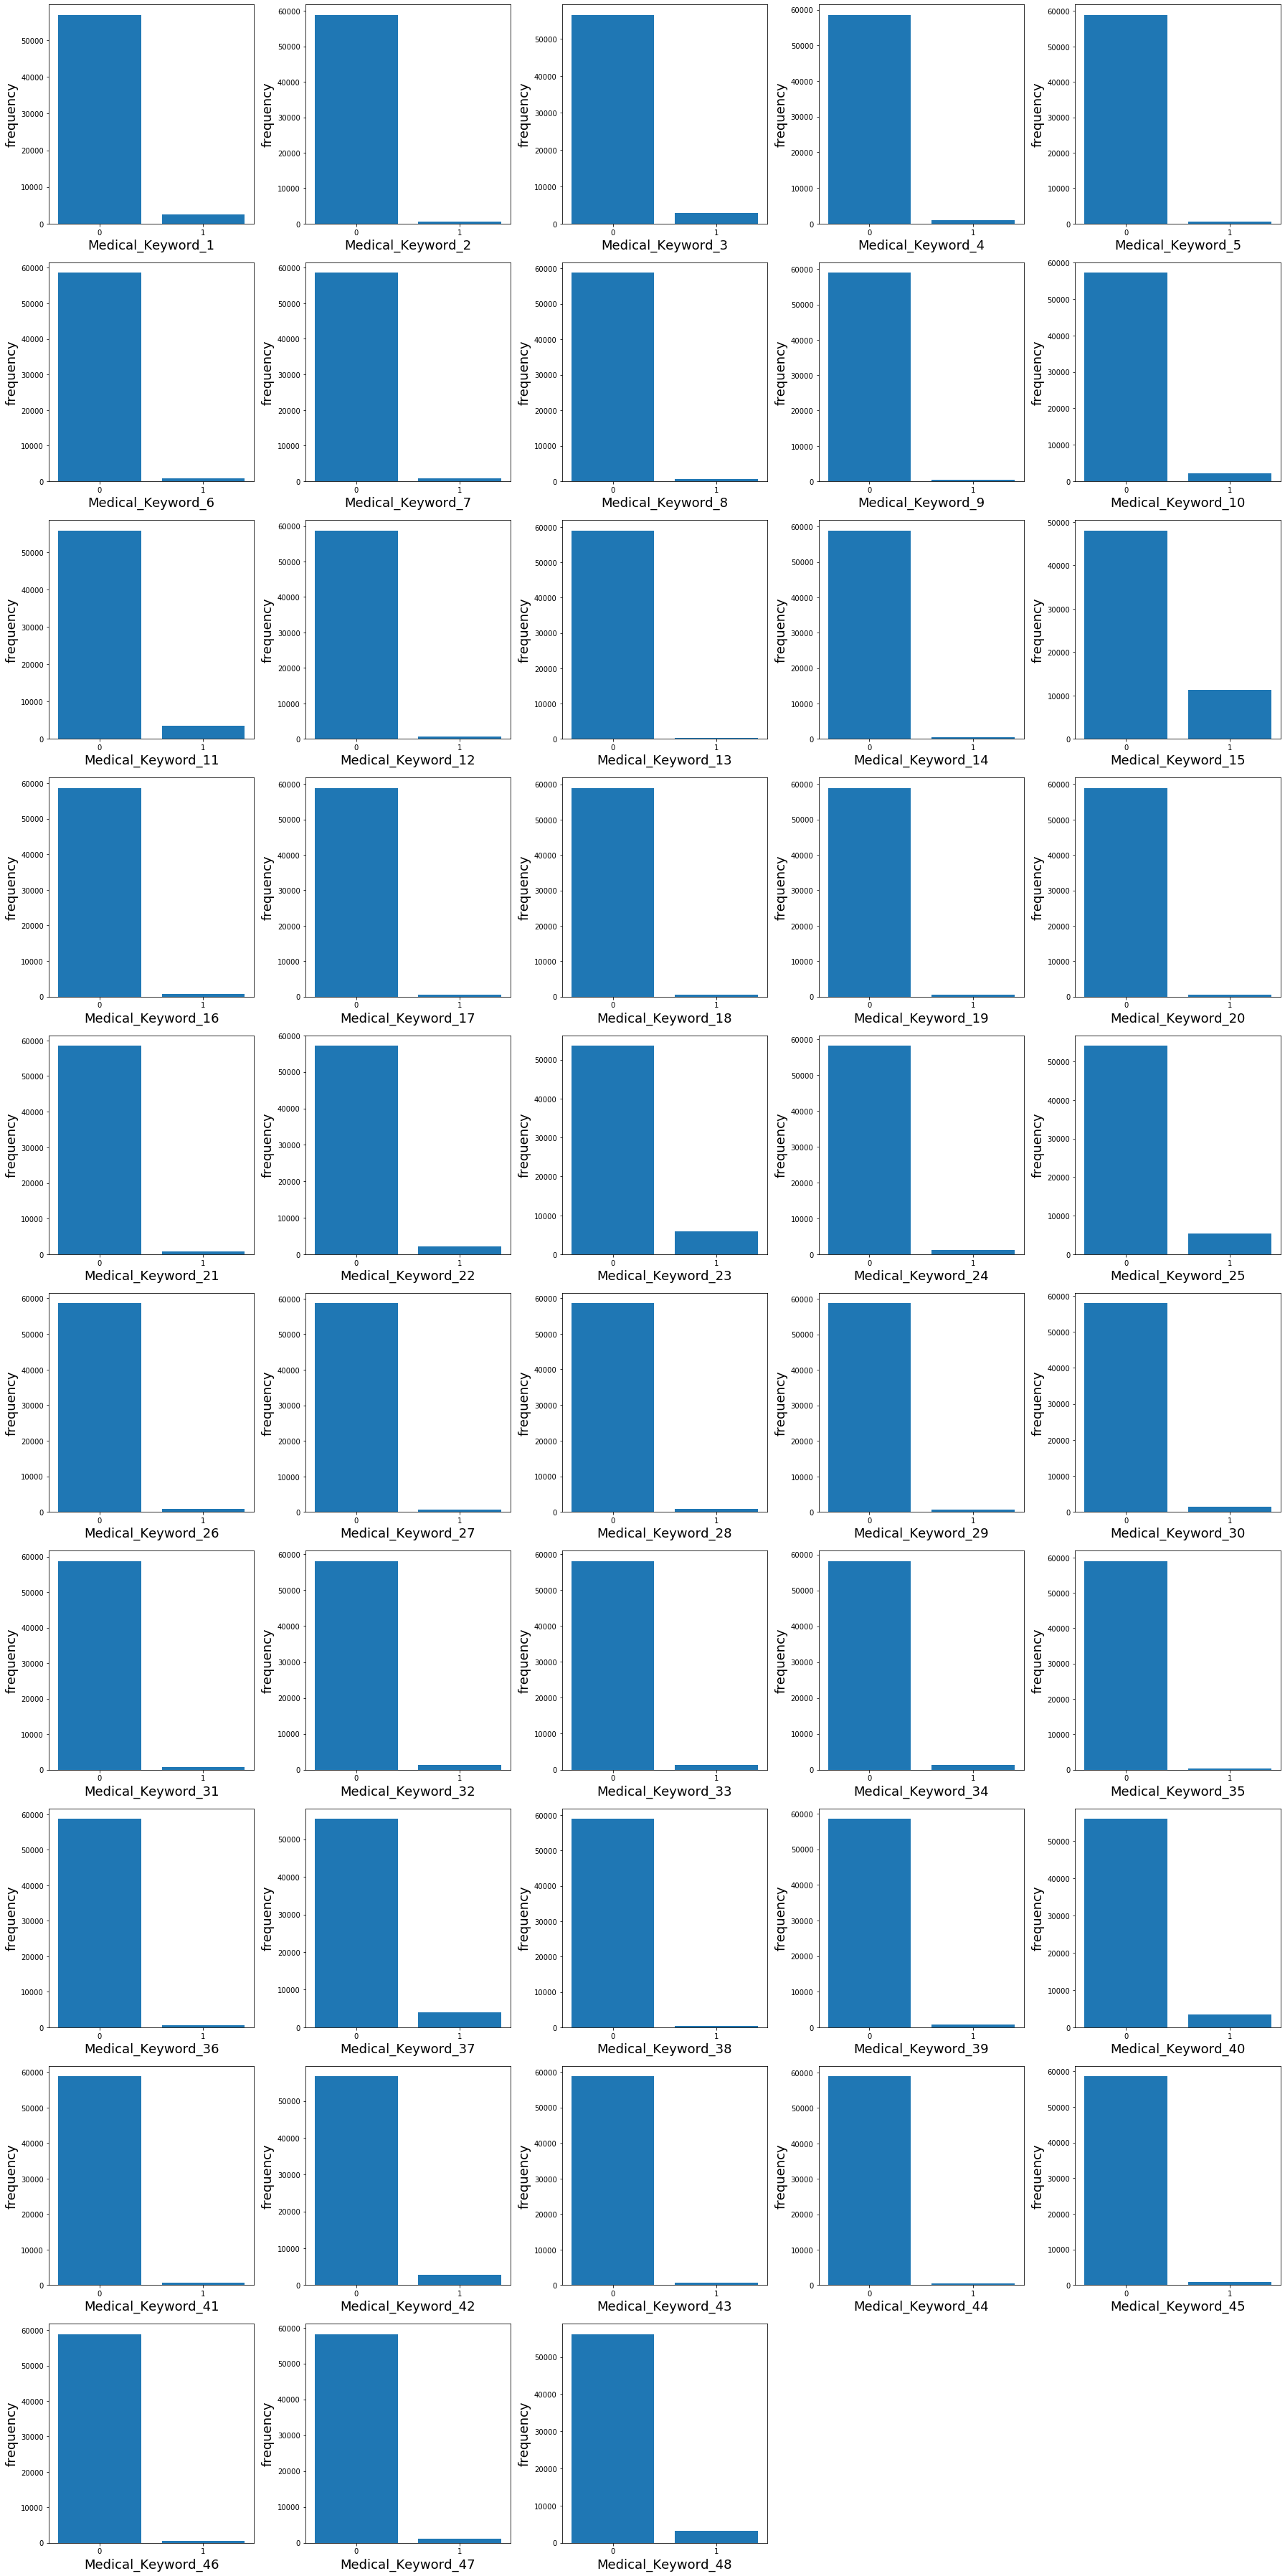

In [4]:
# look at the dummy variables
def plot_categoricals(data):
    ncols = len(data.columns)
    fig = plt.figure(figsize=(5 * 5, 5 * (ncols // 5 + 1)))
    for i, col in enumerate(data.columns):
        cnt = Counter(data[col])
        keys = list(cnt.keys())
        vals = list(cnt.values())
        plt.subplot(ncols // 5 + 1, 5, i + 1)
        plt.bar(range(len(keys)), vals, align="center")
        plt.xticks(range(len(keys)), keys)
        plt.xlabel(col, fontsize=18)
        plt.ylabel("frequency", fontsize=18)
    fig.tight_layout()
    plt.show()
    
plot_categoricals(df_train[dummy_cols])

Well, they are all binary with most values being zero

#### Categorical columns

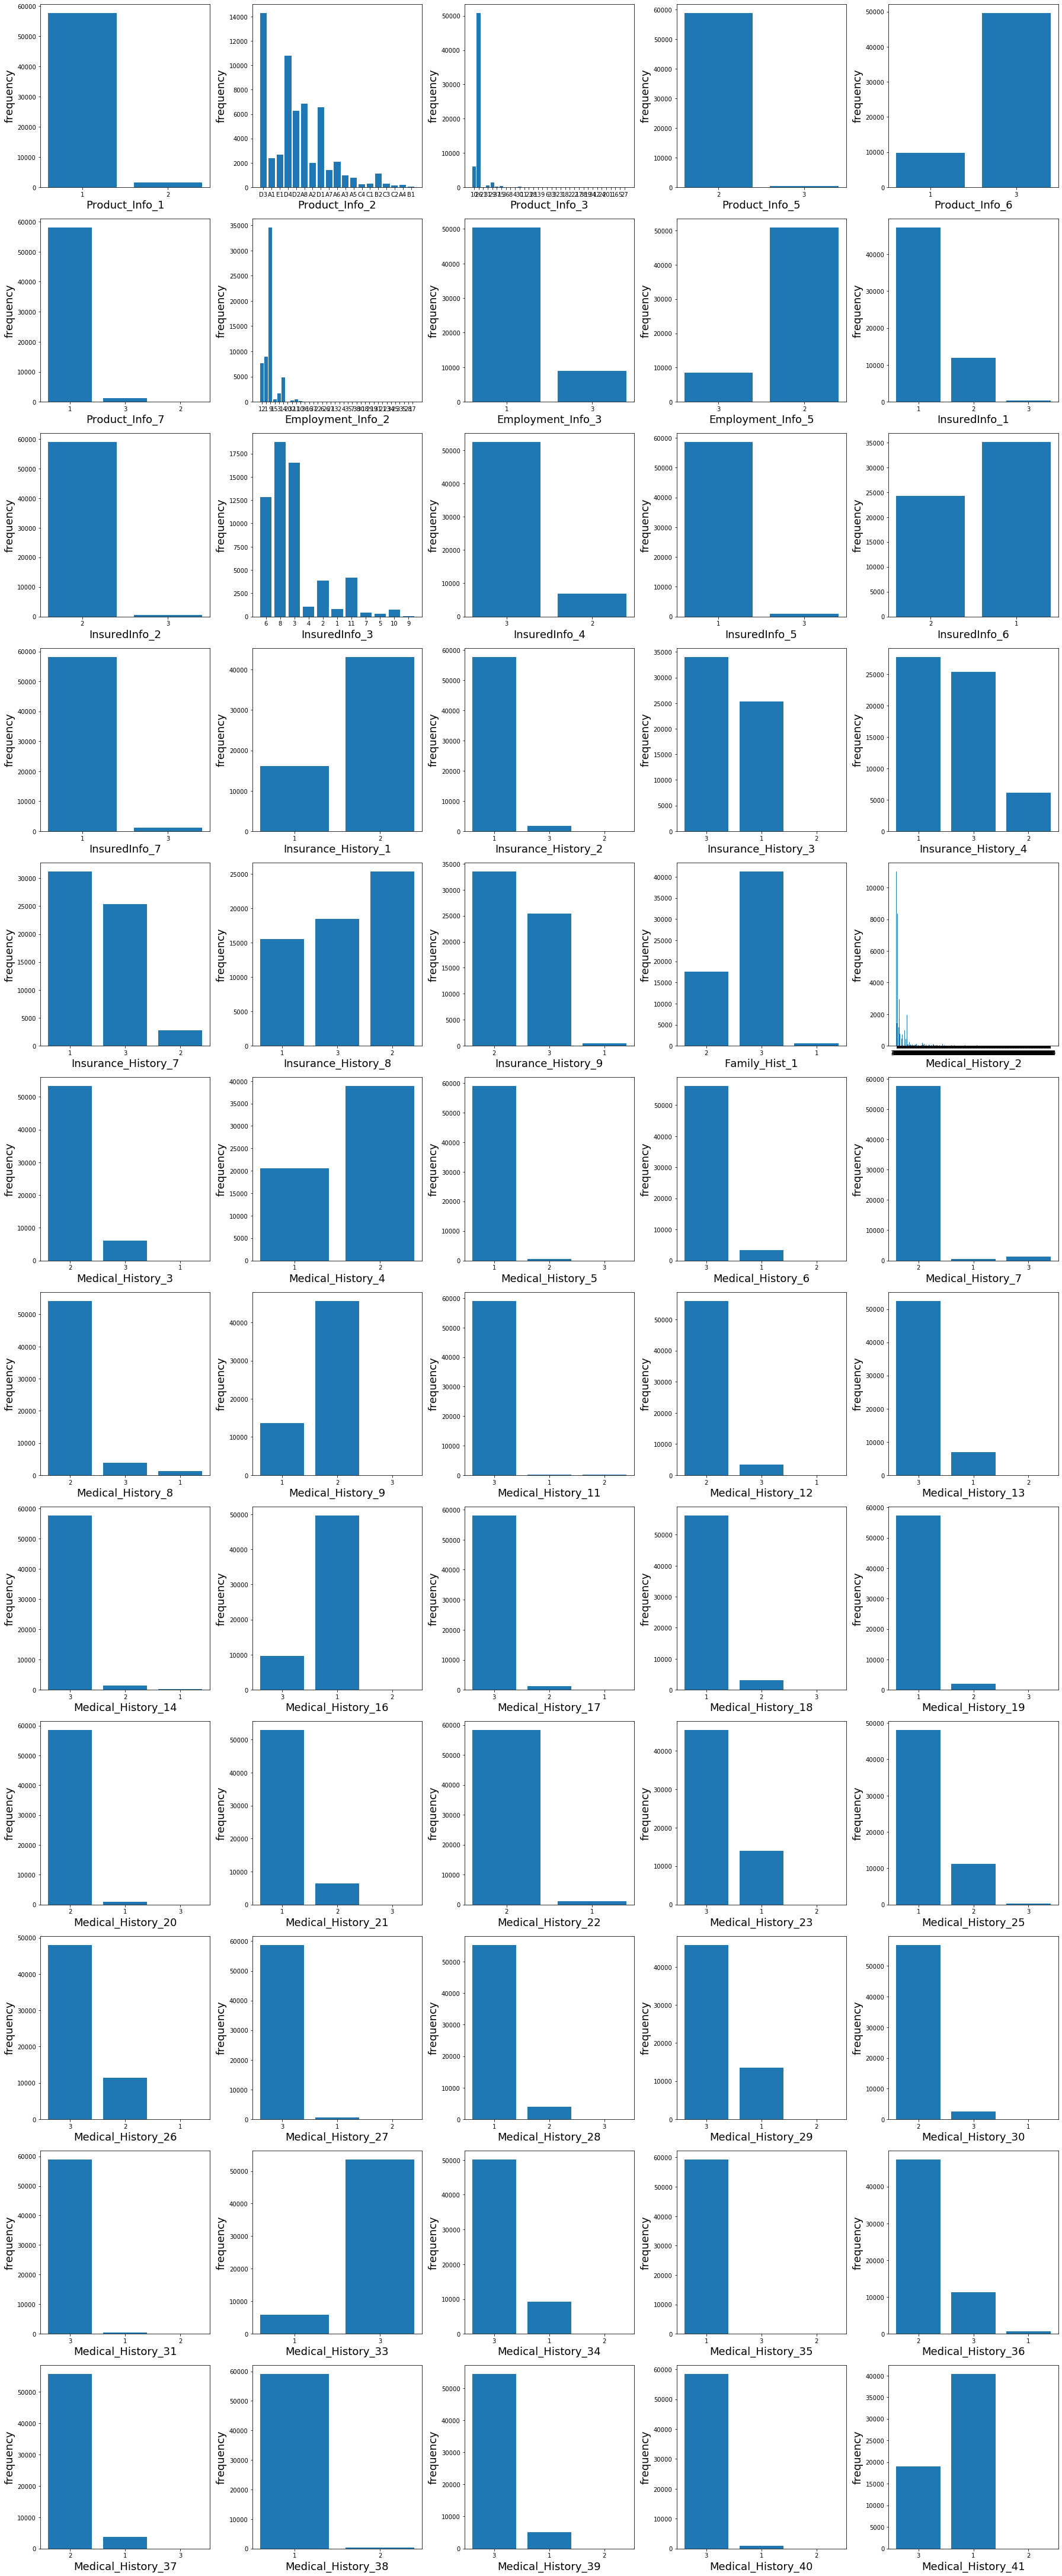

In [5]:
# take a look at the categorical columns without the id column
plot_categoricals(df_train[cat_cols[1:]])

Note that many values are appearing only in small numbers, so they might be not in the training set. When encoding, we must pass the whole dictionary before or use out-of-volume (oov) buckets.
Lets take a closer look at Product_Info_3,Product_Info_7, Employment_Info_2, Insurance_History_3, Medical_History_2, Medical_History_3, Medical_History_5, Medical_History_6, Medical_History_9, Medical_History_12, Medical_History_13

Int64Index([  1,   2,   3,   5,   6,   7,   8,   9,  10,  12,
            ...
            639, 640, 641, 642, 643, 644, 645, 646, 647, 648],
           dtype='int64', length=579)


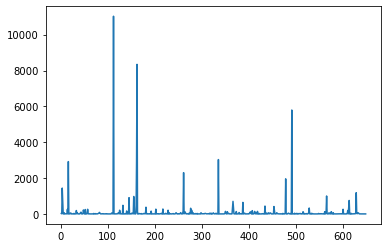

In [6]:
print(df_train['Medical_History_2'].value_counts().sort_index().index)
df_train['Medical_History_2'].value_counts().sort_index().plot()

So the values there range from 1 to 648, most number only appearing once. Therefore, we will not onehotencode this and treat it as an discrete column or use the sklearn KBinsDiscretizer and onehotencode. The same goes for Product_Info_3 and Employment_Info_2.

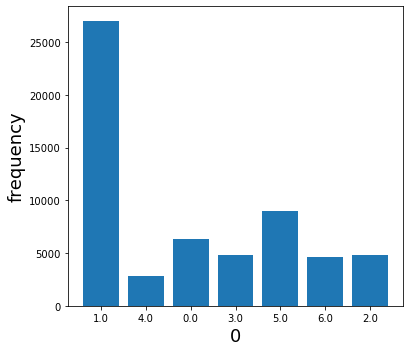

In [35]:
from sklearn.preprocessing import KBinsDiscretizer
kbins = KBinsDiscretizer(n_bins=7, encode='ordinal', strategy='kmeans')
transf = kbins.fit_transform(df_train[['Medical_History_2']])
plot_categoricals(pd.DataFrame(transf))

In [8]:
df_train['Medical_History_5'].value_counts()

1    58946
2      433
3        2
Name: Medical_History_5, dtype: int64

Again, the two 3's will probably not appear, but might be handles with bucket_oov. We will apply these to all other columns. Let's take a look at the id's:

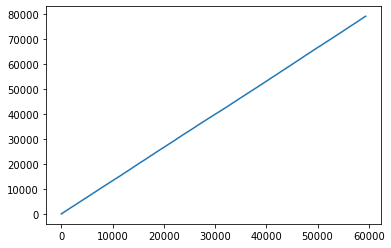

In [9]:
df_train['Id'].plot()

Okay, that's not the identity function, so there are jumps in the rows |--> id function. We will treat this one as a discrete function

#### Continuous columns

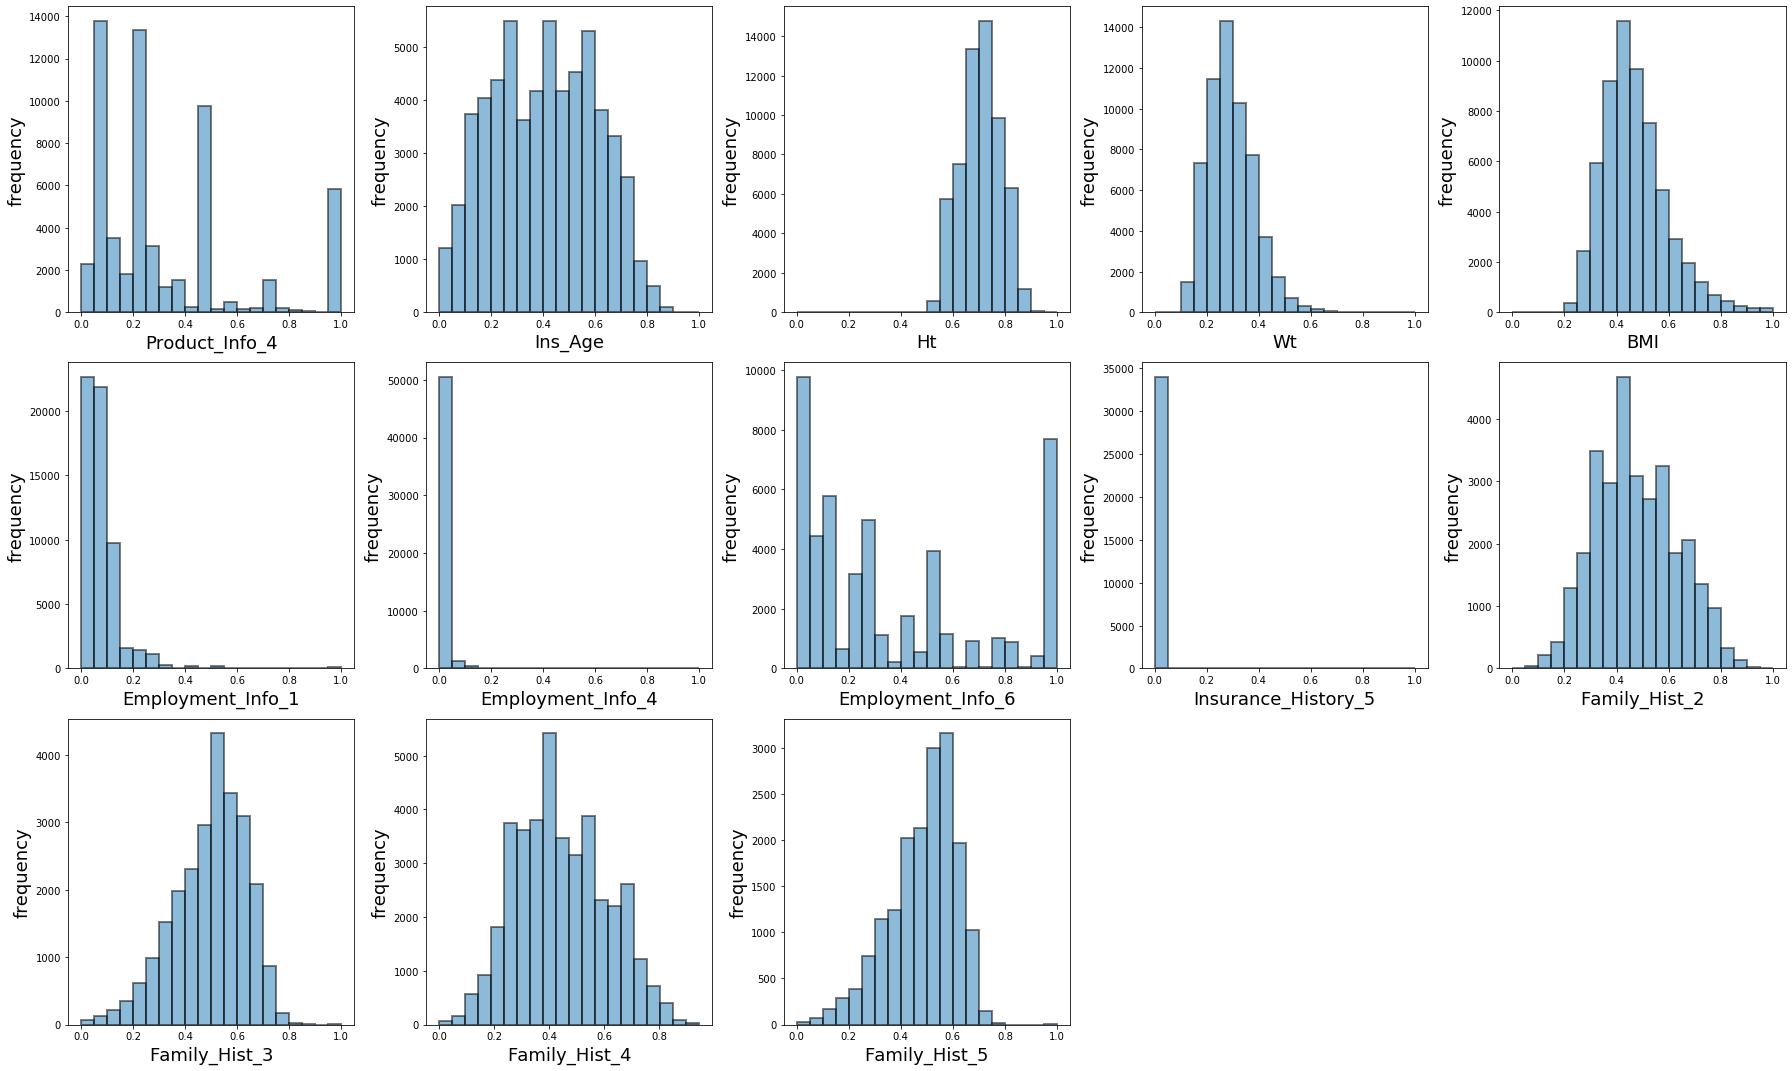

In [10]:
def plot_histograms(data):
    ncols = len(data.columns)
    fig = plt.figure(figsize=(5 * 5, 5 * (ncols // 5 + 1)))
    for i, col in enumerate(data.columns):
        X = data[col].dropna()
        plt.subplot(ncols // 5 + 1, 5, i + 1)
        plt.hist(X, bins=20, alpha=0.5, \
                 edgecolor="black", linewidth=2.0)
        plt.xlabel(col, fontsize=18)
        plt.ylabel("frequency", fontsize=18)
    fig.tight_layout()
    plt.show()

plot_histograms(df_train[cont_cols])

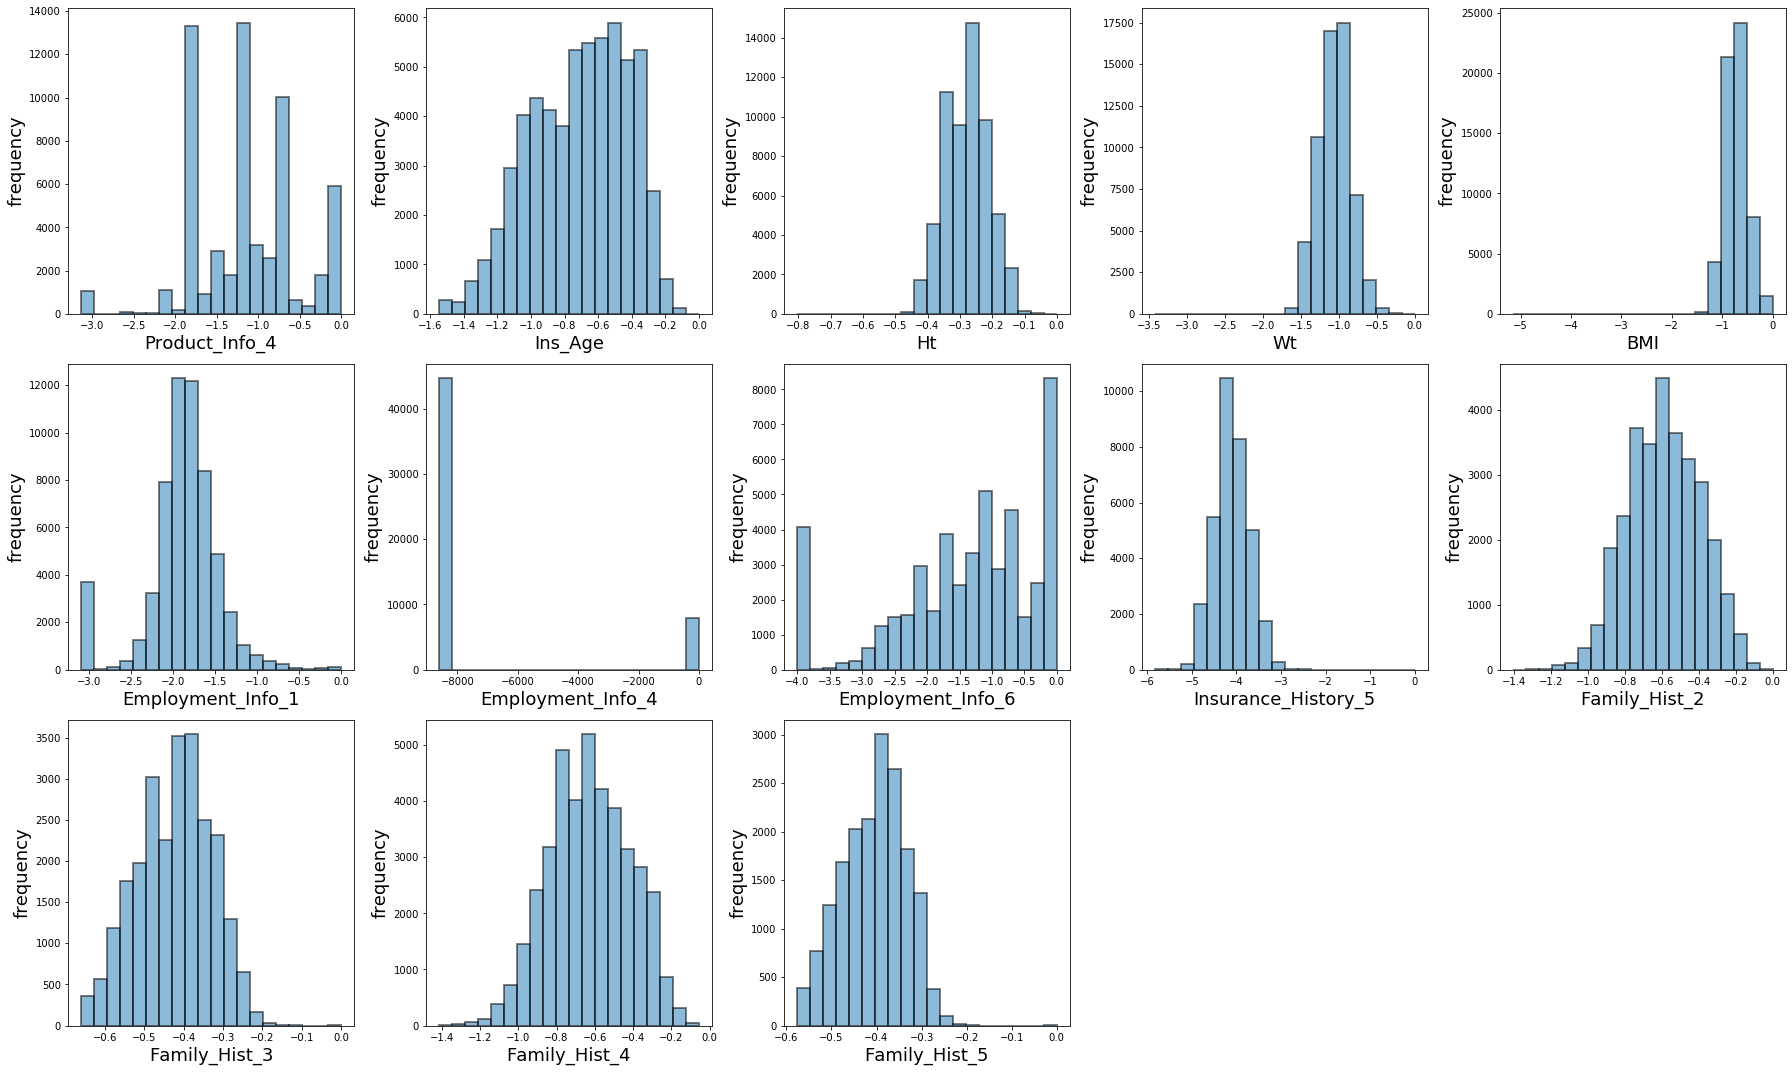

In [11]:
# We are going to make the data look more Gaussian distributed by using boxcox transformation
# The boxcox itself and normalization will be done in the layers.
# Note that we have to store the lambda in boxcox beforehand so we will apply the same transformation
# to all data
from scipy.stats import boxcox

eps = 1e-10 # so that boxcox does not have to be applied on zeros
def boxcox_transf(arr):
    """Applies boxcox to all values not nan"""
    # only apply the boxcox to the non-nan values
    arr[~np.isnan(arr)], _ = boxcox(arr[~np.isnan(arr)])
    return arr

# plot the boxcox diagrams, the method apply on a dataframe raises some issue with non-positive values
# presumably coming from handling the nans
cont_boxcox = df_train[cont_cols].copy()
for col in cont_cols:
    cont_boxcox[col] = boxcox_transf(cont_boxcox[col]+eps)

plot_histograms(cont_boxcox)

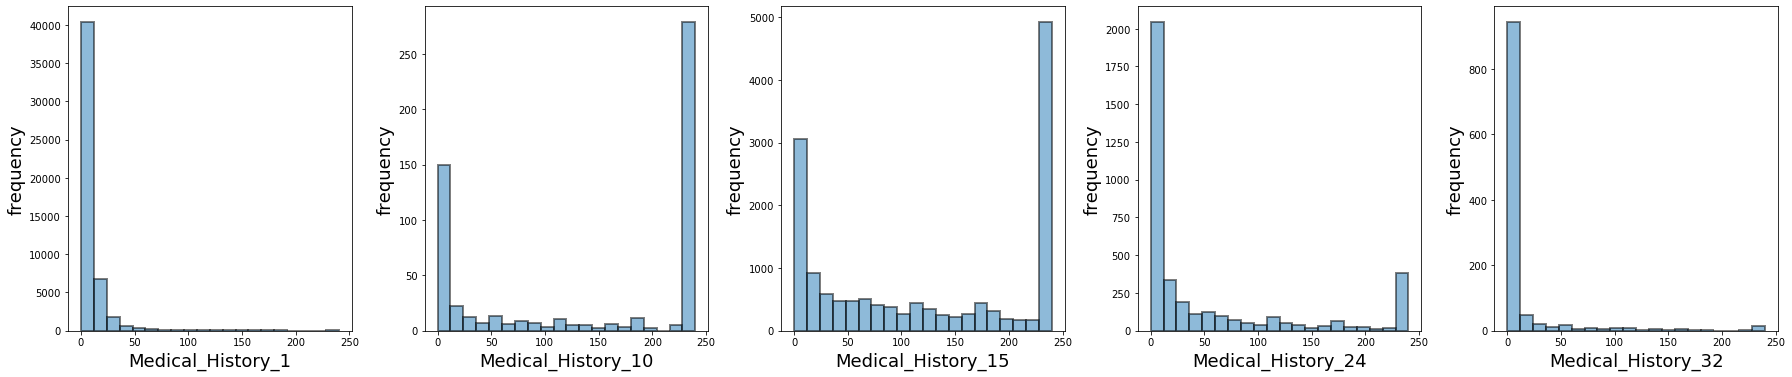

In [12]:
#### Discrete columns
plot_histograms(df_train[disc_cols])

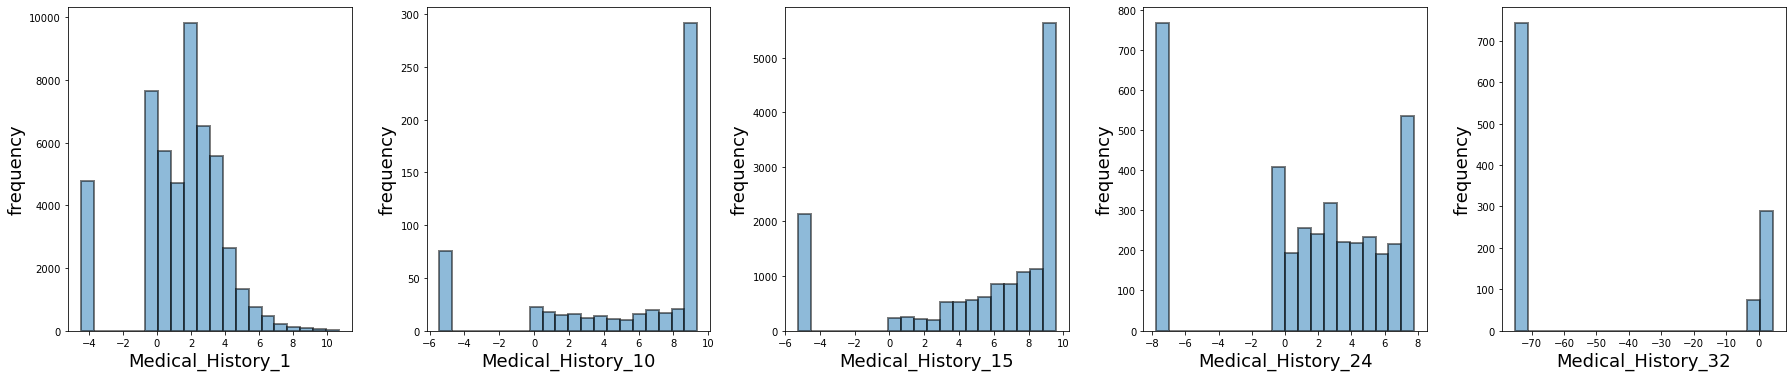

In [13]:
disc_boxcox = df_train[disc_cols].copy()
for col in disc_cols:
    disc_boxcox[col] = boxcox_transf(disc_boxcox[col]+eps)

plot_histograms(disc_boxcox)

Well, that does not really look satisfying, but we leave it like that

### Splitting the Data into Train and Test

In [14]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_train, test_size=0.2, stratify=df_train['Response'].values, random_state=43)
train, val = train_test_split(train, test_size=0.2, stratify=train['Response'].values, random_state=43)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

38003 train examples
9501 validation examples
11877 test examples


### Produce pipelines

So we are left with the following input to be preprocessed:

- Id, Medical_History_2, Product_Info_3 and Employment_Info_2 are considered as discrete data
- continuous and discrete data will be boxcoxed and normalized. If implementing yourself, beware of storing the parameter lambda of boxcoxing train set because when applying it to test and validation data, it must be the same
- dummy and categorical should be onehotencoded with a oov_bucket size 1.


This gives us essentially two types of input data.

In [131]:
# specify which attributes should be applied to KBinsDiscretizer with number of bins
kbins_2_attribs = ['Employment_Info_1','Employment_Info_4','Insurance_History_5',
                   'Medical_History_1','Medical_History_10','Medical_History_15', 'Medical_History_24',
                  'Medical_History_32']
kbins_3_attribs = ['Product_Info_3', 'Employment_Info_2']
kbins_4_attribs = ['Product_Info_4', 'Employment_Info_6']
kbins_7_attribs = ['Medical_History_2']
kbins = kbins_2_attribs+kbins_3_attribs+kbins_4_attribs+kbins_7_attribs


# specifying which columns are numerical and which categorical
cat_attribs = [col for col in cat_cols + dummy_cols
               if col not in ['Id','Medical_History_2', 'Product_Info_3', 'Employment_Info_2']]

num_attribs = [x for x in df_train.columns if x not in cat_attribs and x not in ['Response']]
print("Length of num_attribs + cat_attribs + kbins is equal to", len(num_attribs+cat_attribs), "and should be 127")

Length of num_attribs + cat_attribs + kbins is equal to 127 and should be 127


There are ways of preprocessing DataFrames in Tensorflow, like turning a DataFrame to a tf.dataset like

    A utility method to create a tf.data dataset from a Pandas Dataframe
    
    def df_to_dataset(dataframe, shuffle=True, batch_size=32):
        dataframe = dataframe.copy()
        labels = dataframe.pop('Response') - 1 # normalize the labels to be in the range 0 to 7, for the last softmax layer
        ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
        if shuffle:
            ds = ds.shuffle(buffer_size=len(dataframe))
        ds = ds.batch(batch_size)
        return ds

and then using tf.feature_column or so, but I am not into that right now and will use sklearn preprocessing steps, keeping in mind to manually apply them whenever the model will predict something.

In [132]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


num_pt_pipeline = Pipeline([('yeo_jo', PowerTransformer()), # applies yeo-johnson (similar to boxcox, but can be used for non-positive as well)
                             ('sim_imp', SimpleImputer(strategy='constant',fill_value=0))]# after standardization, medium is zero
                           )
num_npt_pipeline = Pipeline([('sim_imp', SimpleImputer(strategy='mean',fill_value=0))] # does not standardize, possibly id
                           )

# some pipelines for using KBinsDiscretizer, are not used as results are worse
kbins_2_pipe = Pipeline([('sim_imp', IterativeImputer()),
                        ('kbins', KBinsDiscretizer(n_bins=2, encode='onehot', strategy='kmeans'))]
                           )
kbins_3_pipe = Pipeline([('sim_imp', SimpleImputer(strategy='constant',fill_value=0)),
                        ('kbins', KBinsDiscretizer(n_bins=3, encode='onehot', strategy='kmeans'))]
                           )
kbins_4_pipe = Pipeline([('sim_imp', SimpleImputer(strategy='constant',fill_value=0)),
                        ('kbins', KBinsDiscretizer(n_bins=4, encode='onehot', strategy='kmeans'))]
                           )
kbins_7_pipe = Pipeline([('sim_imp', SimpleImputer(strategy='constant',fill_value=0)),
                        ('kbins', KBinsDiscretizer(n_bins=7, encode='onehot', strategy='kmeans'))]
                           )

# handle_unknown='ignore' sets everything to zero if unknown category is encountered
# there seems to be no easy way to implement oov_bucket except for writing own class
cat_pipeline = Pipeline([('one_hot', OneHotEncoder(handle_unknown='ignore'))])

full_pipeline = ColumnTransformer([
    ('num', num_pt_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs)
#    ('kbins_2',kbins_2_pipe,kbins_2_attribs),
#    ('kbins_3',kbins_2_pipe, kbins_3_attribs),
#    ('kbins_4',kbins_2_pipe, kbins_4_attribs),
#    ('kbins_7',kbins_2_pipe, kbins_7_attribs)
    ],
    remainder='drop') # remainder='drop' is default and drops all columns not in num_attribs or cat_attribs

### Keras first shot

At first, we just start with the numerical attributes, throwing away everything else (i.e. nans and Product_Info_2) to get started.

In [53]:
# converting labels to numpy arrays, as keras will expect
# note that the pipeline will convert the dataframes to numpy arrays, the onehots being flattened
# so there is no need for to_numpy here

y_train = train.pop('Response').to_numpy() - 1 # so that target values range from 0 to 7, because keras.layers.Dense(8, activation='softmax') expecting range [0,8)
y_val = val.pop('Response').to_numpy() - 1
y_test = test.pop('Response').to_numpy() - 1

KeyError: 'Response'

In [133]:
# train the pipeline
full_pipeline.fit(train)

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('num',
                                 Pipeline(memory=None,
                                          steps=[('yeo_jo',
                                                  PowerTransformer(copy=True,
                                                                   method='yeo-johnson',
                                                                   standardize=True)),
                                                 ('sim_imp',
                                                  SimpleImputer(add_indicator=False,
                                                                copy=True,
                                                                fill_value=0,
                                                                missing_values=nan,
                                                                strategy='constant',
        

In [139]:
# define the 1cycle by Leslie Smith
import tensorflow as tf
import keras
import keras.backend as K

class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [144]:
np.random.seed(43)
tf.random.set_seed(43)
#from tensorflow_addons.metrics.cohens_kappa import CohenKappa # module must be installed via pip in console


# we define a function that returns a sequential model already defined with standard settings as in Geron,
# Hands-on machine learning p. 371
def get_seq_model(output_neurons=None, output_activation=None, n_hidden=2,n_neurons = 100,input_shape=None,
                       batch_normal=True,dropout_rate=0,activation='elu',kernel_initializer='he_normal'):
    model = keras.models.Sequential()
    
    if input_shape is not None:
        model.add(keras.layers.Flatten(input_shape=input_shape))
    
    for i in range(n_hidden): # add the hidden layers in order (some layers if set to true) dropout, normalization, dense
        if dropout_rate != 0:
            model.add(keras.layers.Dropout(rate=dropout_rate))
        if batch_normal:
            model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Dense(n_neurons, activation=activation, kernel_initializer=kernel_initializer))
    
    # set the last layers
    if dropout_rate != 0:
            model.add(keras.layers.Dropout(rate=dropout_rate))
    if batch_normal:
            model.add(keras.layers.BatchNormalization())
    if output_neurons is not None and output_activation is not None:
        model.add(keras.layers.Dense(output_neurons, activation=output_activation, kernel_initializer=kernel_initializer))
    
    return model
    
def get_seq_comp_model(output_neurons, output_activation,loss,metrics,optimizer='nadam',n_hidden=2,n_neurons = 100,
                       input_shape=None, batch_normal=True,dropout_rate=0,activation='elu',
                       kernel_initializer='he_normal'):
    
    model = get_seq_model(output_neurons=output_neurons, output_activation=output_activation, n_hidden=n_hidden,
                          n_neurons = n_neurons,input_shape=input_shape, batch_normal=batch_normal,
                          dropout_rate=dropout_rate, activation=activation,kernel_initializer=kernel_initializer)
    
    model.compile(optimizer=optimizer,loss=loss,metrics=metrics)
    
    return model


model = get_seq_comp_model(8,'softmax',loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'],n_hidden=5,n_neurons = 500)

In [145]:
def fit_model(model, X_train,y_train,X_val,y_val,batch_size=32,n_epochs=10,early_stopping_patience=5,
              onecycle_max_rate=0.05):
    """fits a model and returns history"""
    onecycle = OneCycleScheduler(len(X_train) // batch_size * n_epochs, max_rate=onecycle_max_rate)
    if early_stopping_patience == 0:
        callbacks=[onecycle]
    else:
        early_stopping_cb = keras.callbacks.EarlyStopping(patience=early_stopping_patience,
                                                          restore_best_weights=True)
        callbacks=[onecycle,early_stopping_cb]
        
    history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                    callbacks=callbacks, validation_data=(X_val,y_val))
    return history
    
# note that we must apply the transformed data
history = fit_model(model,full_pipeline.transform(train), y_train,
                    full_pipeline.transform(val),y_val,n_epochs=30,early_stopping_patience=10,
                   onecycle_max_rate=0.05)

Train on 38003 samples, validate on 9501 samples
Epoch 1/30
38003/38003 [==============================] - 29s 773us/step - loss: 1.5077 - accuracy: 0.4634 - val_loss: 1.4091 - val_accuracy: 0.5056
Epoch 2/30
38003/38003 [==============================] - 27s 713us/step - loss: 1.3226 - accuracy: 0.5111 - val_loss: 1.3343 - val_accuracy: 0.5122
Epoch 3/30
38003/38003 [==============================] - 28s 740us/step - loss: 1.3078 - accuracy: 0.5200 - val_loss: 1.4450 - val_accuracy: 0.4634
Epoch 4/30
38003/38003 [==============================] - 27s 711us/step - loss: 1.3039 - accuracy: 0.5190 - val_loss: 1.3494 - val_accuracy: 0.5190
Epoch 5/30
38003/38003 [==============================] - 27s 720us/step - loss: 1.2965 - accuracy: 0.5237 - val_loss: 1.3479 - val_accuracy: 0.5096
Epoch 6/30
38003/38003 [==============================] - 27s 714us/step - loss: 1.2943 - accuracy: 0.5264 - val_loss: 1.7589 - val_accuracy: 0.5190
Epoch 7/30
38003/38003 [==============================] -

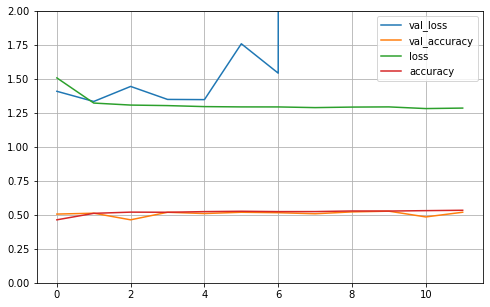

In [146]:
def show_history(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,2) # sets vertical range to interval [0,1]
    plt.show()
    
show_history(model.history)

In [147]:
from sklearn.metrics import cohen_kappa_score
score = cohen_kappa_score(y_val, model.predict_classes(full_pipeline.transform(val)),weights='quadratic')
score

0.5693367852584048

In [148]:
test_score = cohen_kappa_score(y_test, model.predict_classes(full_pipeline.transform(test)),weights='quadratic')
test_score

0.5712801196924773

What we did is essentially two things: We powertransformed the data (which gave roughly a boost of 0.06, not displayed in this notebook) and we tried the KBinDiscretizer, making our predictions worse (again, only code in the notebook and no execution).
Given that the top scorers on kaggle achieve 0.68 to 0.69, that is quite bad. At least, we did not overfit the data. Let's take a quick glance on how some quick vanilla scikit-learn estimators perform:

In [154]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, Ridge
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from sklearn.pipeline import make_pipeline

log_reg = make_pipeline(StandardScaler(),LogisticRegression(random_state=43))
sgd = make_pipeline(StandardScaler(),SGDClassifier(random_state=43))
rnd_for = make_pipeline(StandardScaler(),RandomForestClassifier(random_state=43, n_jobs = -1))
neu_net = make_pipeline(StandardScaler(),MLPClassifier(random_state=43))

clf_list = [('log_reg',log_reg),('sgd',sgd),('rnd_for',rnd_for),('neu_net',neu_net)]

In [155]:
for clf_name, clf in clf_list:
    clf.fit(full_pipeline.transform(train), y_train)
    print("Score of", clf_name, "on validation:", cohen_kappa_score(y_val, clf.predict(full_pipeline.transform(val)),weights='quadratic'))
    print("Score of", clf_name, "on test:", cohen_kappa_score(y_test, clf.predict(full_pipeline.transform(test)),weights='quadratic'))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Score of log_reg on validation: 0.5388314805435217
Score of log_reg on test: 0.5334536937494707
Score of sgd on validation: 0.4550833745985915
Score of sgd on test: 0.4661647199284721
Score of rnd_for on validation: 0.5319601853175792
Score of rnd_for on test: 0.5408338982330063


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Score of neu_net on validation: 0.4845596395438092
Score of neu_net on test: 0.5065976721444658


If not much, we are at least a little bit better, but we did not any fine-tuning with the scikit-guys (and we could do more fine tuning on our model, but it is not worth its efforts as we are far away from being competitive).

Next idea would be to implement multiple output in our model. By now, the metric is accuracy and it is unimportant if I miss a 5 by 6 or 8. On the other hand, the Cohen-Kappa punishes a difference of 3 much more heavily than a difference of 1. To train the network giving up accuracy a little bit for hitting near the right one, we would implement another output which predicts if the label has distance smaller than 1.